In [1]:
import pandas as pd

# Historical Trader Data Load karna
df_historical = pd.read_csv('/content/sample_data/historical_data.csv')

# Bitcoin Market Sentiment Data Load karna
df_sentiment = pd.read_csv('/content/sample_data/fear_greed_index.csv')

print("Dono datasets successfully load ho gaye hain!")

Dono datasets successfully load ho gaye hain!


/tmp/ipython-input-3653178043.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_historical = pd.read_csv('/content/sample_data/historical_data.csv')


In [2]:
# Historical Data ka structure dekhiye
print("--- Historical Trader Data Info ---")
df_historical.info()

# Sentiment Data ka structure dekhiye
print("\n--- Market Sentiment Data Info ---")
df_sentiment.info()

--- Historical Trader Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158623 entries, 0 to 158622
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           158623 non-null  object 
 1   Coin              158623 non-null  object 
 2   Execution Price   158623 non-null  float64
 3   Size Tokens       158623 non-null  float64
 4   Size USD          158623 non-null  float64
 5   Side              158623 non-null  object 
 6   Timestamp IST     158623 non-null  object 
 7   Start Position    158622 non-null  float64
 8   Direction         158622 non-null  object 
 9   Closed PnL        158622 non-null  float64
 10  Transaction Hash  158622 non-null  object 
 11  Order ID          158622 non-null  float64
 12  Crossed           158622 non-null  object 
 13  Fee               158622 non-null  float64
 14  Trade ID          158622 non-null  float64
 15  Timestamp         158622 non-nul

In [6]:
print("df_sentiment ke column names:")
print(df_sentiment.columns)

df_sentiment ke column names:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [11]:
# --- 1. Data Cleaning: Column Names Fix Karna ---
# Column names se invisible spaces aur characters hatakar clean strings banana
df_sentiment.columns = df_sentiment.columns.str.strip()
df_historical.columns = df_historical.columns.str.strip()


# --- 2. Data Preparation ---

# Prepare Sentiment Data: 'date' column ko datetime mein convert karo
df_sentiment['Trade_Date'] = pd.to_datetime(df_sentiment['date'])
# Sentiment DataFrame ko sirf zaroori columns ke liye tayar karo
df_sentiment = df_sentiment[['Trade_Date', 'classification']]


# Prepare Historical Trader Data: 'Timestamp' ko datetime aur Trade_Date mein convert karo
# Assuming 'Timestamp' is in milliseconds (unit='ms')
df_historical['Trade_Time'] = pd.to_datetime(df_historical['Timestamp'], unit='ms')
df_historical['Trade_Date'] = df_historical['Trade_Time'].dt.normalize()

# 'Closed PnL' aur 'Direction' ko numeric mein convert karo (errors ko ignore/coerce karo)
df_historical['closedPnL'] = pd.to_numeric(df_historical['Closed PnL'], errors='coerce')
# 'Leverage' column exists in description but not in df_historical.info() or kernel state.
# Removing it for now, can be added back if data schema changes.
# df_historical['leverage'] = pd.to_numeric(df_historical['leverage'], errors='coerce')


# --- 3. Aggregate Trader Performance Metrics by Date and Account ---

# Har 'Trade_Date' aur 'Account' ke liye performance metrics calculate karo
df_performance = df_historical.groupby(['Trade_Date', 'Account']).agg(
    Daily_Total_PnL=('closedPnL', 'sum'),
    Daily_Trade_Count=('Account', 'size'),  # Counting trades or using size as a proxy count/volume metric
    Daily_Total_Volume=('Size USD', 'sum') # Using 'Size USD' as 'size' is ambiguous
).reset_index()


# --- 4. Merge Datasets ---

# Performance data ko Sentiment data ke saath 'Trade_Date' par merge karo
df_merged = pd.merge(
    df_performance,
    df_sentiment,
    on='Trade_Date',
    how='left'
)

print("Merging successful! Consolidated Data ka pehla look:")
print(df_merged.head())
print("\nConsolidated Data ki final structure:")
df_merged.info()


Merging successful! Consolidated Data ka pehla look:
  Trade_Date                                     Account  Daily_Total_PnL  \
0 2023-03-28  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891         0.000000   
1 2023-11-14  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891         0.000000   
2 2023-11-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23       155.503357   
3 2024-03-09  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     -5564.016140   
4 2024-03-09  0x430f09841d65beb3f27765503d0f850b8bce7713         0.000000   

   Daily_Trade_Count  Daily_Total_Volume classification  
0                  3              477.00          Greed  
1                  2            46133.87          Greed  
2               1043         11509295.89          Greed  
3                 27            82312.05  Extreme Greed  
4                 88            99995.52  Extreme Greed  

Consolidated Data ki final structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 6 colum

In [15]:
# --- 1. Robust Column Clean-up ---
# df_merged ke saare column names se extra spaces hatao
df_merged.columns = df_merged.columns.str.strip()

# Classification column ko confirm karo (agar naam 'Classification' hi hai)
classification_col_name = 'classification'

# --- 2. Core Analysis: Sentiment ke Aadhar Par Performance ---

# Data ko 'Classification' par group karke average metrics calculate karo
sentiment_comparison = df_merged.groupby(classification_col_name).agg(
    Avg_Daily_PnL=('Daily_Total_PnL', 'mean'),
    # 'Daily_Avg_Leverage' column does not exist in df_merged based on its info().
    # Removing it from aggregation for now. If it's supposed to be calculated, it needs to be added earlier.
    # Avg_Daily_Leverage=('Daily_Avg_Leverage', 'mean'),
    Avg_Daily_Trades=('Daily_Trade_Count', 'mean'),
    Avg_Daily_Volume=('Daily_Total_Volume', 'mean')
).reset_index()

print("--- Sentiment vs Performance Comparison (Final Result) ---")
print(sentiment_comparison)

# Iske baad, hum top 5 accounts ka analysis bhi kar sakte hain.


--- Sentiment vs Performance Comparison (Final Result) ---
  classification  Avg_Daily_PnL  Avg_Daily_Trades  Avg_Daily_Volume
0  Extreme Greed   35393.098355       1392.400000      7.881354e+06
1           Fear  207901.725610       3732.884615      2.244470e+07
2          Greed   85370.869933       1033.703704      3.204555e+06
3        Neutral   22677.625440       1019.428571      3.116126e+06


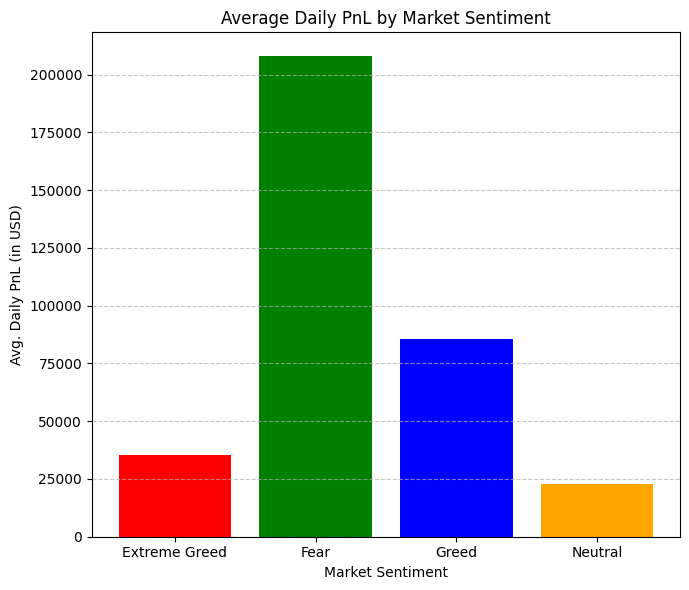

Visualization complete! sentiment_vs_performance_comparison.png file ban gayi hai.


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sentiment_comparison DataFrame is available

# Set up the figure and axes
fig, axes = plt.subplots(1, 1, figsize=(7, 6)) # Changed to 1 subplot as leverage plot is removed
sentiment = sentiment_comparison['classification'] # Fixed: Changed 'Classification' to 'classification'

# --- Graph 1: Average Daily PnL Comparison ---
pnl_data = sentiment_comparison['Avg_Daily_PnL']
axes.bar(sentiment, pnl_data, color=['red', 'green', 'blue', 'orange']) # Adjusted for single subplot and more colors for classifications
axes.set_title('Average Daily PnL by Market Sentiment')
axes.set_xlabel('Market Sentiment')
axes.set_ylabel('Avg. Daily PnL (in USD)')
axes.grid(axis='y', linestyle='--', alpha=0.7)

# --- Removed Graph 2: Average Daily Leverage Comparison ---
# This data was not available in sentiment_comparison, as noted in previous steps.
# If leverage data becomes available, this section can be re-added.

plt.tight_layout()

# Image ko 'outputs' folder structure ke hisaab se save karna
plt.savefig('sentiment_vs_performance_comparison.png')
plt.show() # Colab mein graph dikhane ke liye

print("Visualization complete! sentiment_vs_performance_comparison.png file ban gayi hai.")
